In [ ]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.models import vit_b_16
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn.functional import cross_entropy
from torchvision.datasets import ImageFolder

In [ ]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes

    def forward(self, x, target):
        pred = x.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

### 參數與路徑設定

In [ ]:
# === 設定參數 ===
data_dir = "wall_resize"
batch_size = 32
epochs = 50
num_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 資料增強與讀取

In [ ]:
# === 定義轉換 ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.RandomAffine(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === 載入資料集與劃分 ===
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print("Class to index mapping:", dataset.class_to_idx)

Class to index mapping: {'Diagonal': 0, 'Diagonal_large': 1, 'Horizontal': 2, 'Horizontal_large': 3, 'Vertical': 4, 'Vertical_large': 5, 'Web': 6, 'Web_large': 7, 'X-shape': 8, 'spalling-like_cracks': 9}


### 建立與微調 ViT 模型

In [ ]:
model = vit_b_16(pretrained=True)
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
model = model.to(device)

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Train

In [ ]:
criterion = LabelSmoothingLoss(classes=num_classes, smoothing=0.1)


optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=20)
use_amp = torch.cuda.is_available()
scaler = torch.amp.GradScaler(enabled=use_amp)

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda' if use_amp else 'cpu', enabled=use_amp):
            outputs = model(images)
            loss = criterion(outputs, labels)  

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    scheduler.step()
    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}")


Epoch 1/50: 100%|██████████| 22/22 [03:27<00:00,  9.45s/it]


[Epoch 1] Train Loss: 1.8055


Epoch 2/50: 100%|██████████| 22/22 [03:24<00:00,  9.31s/it]


[Epoch 2] Train Loss: 1.3468


Epoch 3/50: 100%|██████████| 22/22 [03:32<00:00,  9.66s/it]


[Epoch 3] Train Loss: 1.1121


Epoch 4/50: 100%|██████████| 22/22 [03:28<00:00,  9.46s/it]


[Epoch 4] Train Loss: 0.9624


Epoch 5/50: 100%|██████████| 22/22 [03:28<00:00,  9.46s/it]


[Epoch 5] Train Loss: 0.8326


Epoch 6/50: 100%|██████████| 22/22 [03:28<00:00,  9.47s/it]


[Epoch 6] Train Loss: 0.7310


Epoch 7/50: 100%|██████████| 22/22 [03:28<00:00,  9.48s/it]


[Epoch 7] Train Loss: 0.6740


Epoch 8/50: 100%|██████████| 22/22 [03:34<00:00,  9.74s/it]


[Epoch 8] Train Loss: 0.6470


Epoch 9/50: 100%|██████████| 22/22 [03:36<00:00,  9.86s/it]


[Epoch 9] Train Loss: 0.6236


Epoch 10/50: 100%|██████████| 22/22 [03:36<00:00,  9.83s/it]


[Epoch 10] Train Loss: 0.6212


Epoch 11/50: 100%|██████████| 22/22 [03:36<00:00,  9.83s/it]


[Epoch 11] Train Loss: 0.6109


Epoch 12/50: 100%|██████████| 22/22 [03:35<00:00,  9.82s/it]


[Epoch 12] Train Loss: 0.5957


Epoch 13/50: 100%|██████████| 22/22 [03:36<00:00,  9.83s/it]


[Epoch 13] Train Loss: 0.5812


Epoch 14/50: 100%|██████████| 22/22 [03:36<00:00,  9.83s/it]


[Epoch 14] Train Loss: 0.5751


Epoch 15/50: 100%|██████████| 22/22 [03:36<00:00,  9.85s/it]


[Epoch 15] Train Loss: 0.5723


Epoch 16/50: 100%|██████████| 22/22 [03:36<00:00,  9.84s/it]


[Epoch 16] Train Loss: 0.5672


Epoch 17/50: 100%|██████████| 22/22 [03:37<00:00,  9.88s/it]


[Epoch 17] Train Loss: 0.5667


Epoch 18/50: 100%|██████████| 22/22 [03:37<00:00,  9.88s/it]


[Epoch 18] Train Loss: 0.5650


Epoch 19/50: 100%|██████████| 22/22 [03:36<00:00,  9.85s/it]


[Epoch 19] Train Loss: 0.5651


Epoch 20/50: 100%|██████████| 22/22 [03:37<00:00,  9.86s/it]


[Epoch 20] Train Loss: 0.5650


Epoch 21/50: 100%|██████████| 22/22 [03:36<00:00,  9.85s/it]


[Epoch 21] Train Loss: 0.5642


Epoch 22/50: 100%|██████████| 22/22 [03:37<00:00,  9.87s/it]


[Epoch 22] Train Loss: 0.5628


Epoch 23/50: 100%|██████████| 22/22 [03:37<00:00,  9.87s/it]


[Epoch 23] Train Loss: 0.5636


Epoch 24/50: 100%|██████████| 22/22 [03:37<00:00,  9.88s/it]


[Epoch 24] Train Loss: 0.5625


Epoch 25/50: 100%|██████████| 22/22 [03:37<00:00,  9.87s/it]


[Epoch 25] Train Loss: 0.5613


Epoch 26/50: 100%|██████████| 22/22 [03:37<00:00,  9.87s/it]


[Epoch 26] Train Loss: 0.5602


Epoch 27/50: 100%|██████████| 22/22 [03:36<00:00,  9.86s/it]


[Epoch 27] Train Loss: 0.5610


Epoch 28/50: 100%|██████████| 22/22 [03:37<00:00,  9.89s/it]


[Epoch 28] Train Loss: 0.5685


Epoch 29/50: 100%|██████████| 22/22 [03:37<00:00,  9.88s/it]


[Epoch 29] Train Loss: 0.5631


Epoch 30/50: 100%|██████████| 22/22 [03:37<00:00,  9.87s/it]


[Epoch 30] Train Loss: 0.5645


Epoch 31/50: 100%|██████████| 22/22 [03:36<00:00,  9.86s/it]


[Epoch 31] Train Loss: 0.5676


Epoch 32/50: 100%|██████████| 22/22 [03:36<00:00,  9.83s/it]


[Epoch 32] Train Loss: 0.5730


Epoch 33/50: 100%|██████████| 22/22 [03:36<00:00,  9.85s/it]


[Epoch 33] Train Loss: 0.5700


Epoch 34/50: 100%|██████████| 22/22 [03:36<00:00,  9.84s/it]


[Epoch 34] Train Loss: 0.6050


Epoch 35/50: 100%|██████████| 22/22 [03:36<00:00,  9.83s/it]


[Epoch 35] Train Loss: 0.6855


Epoch 36/50: 100%|██████████| 22/22 [03:36<00:00,  9.84s/it]


[Epoch 36] Train Loss: 0.6419


Epoch 37/50: 100%|██████████| 22/22 [03:36<00:00,  9.85s/it]


[Epoch 37] Train Loss: 0.7308


Epoch 38/50: 100%|██████████| 22/22 [03:36<00:00,  9.86s/it]


[Epoch 38] Train Loss: 0.6392


Epoch 39/50: 100%|██████████| 22/22 [03:36<00:00,  9.86s/it]


[Epoch 39] Train Loss: 0.6160


Epoch 40/50: 100%|██████████| 22/22 [03:36<00:00,  9.85s/it]


[Epoch 40] Train Loss: 0.6224


Epoch 41/50: 100%|██████████| 22/22 [03:37<00:00,  9.89s/it]


[Epoch 41] Train Loss: 0.6239


Epoch 42/50: 100%|██████████| 22/22 [03:36<00:00,  9.86s/it]


[Epoch 42] Train Loss: 0.5929


Epoch 43/50: 100%|██████████| 22/22 [03:36<00:00,  9.84s/it]


[Epoch 43] Train Loss: 0.5903


Epoch 44/50: 100%|██████████| 22/22 [03:36<00:00,  9.85s/it]


[Epoch 44] Train Loss: 0.5794


Epoch 45/50: 100%|██████████| 22/22 [03:37<00:00,  9.87s/it]


[Epoch 45] Train Loss: 0.5682


Epoch 46/50: 100%|██████████| 22/22 [03:37<00:00,  9.87s/it]


[Epoch 46] Train Loss: 0.5764


Epoch 47/50: 100%|██████████| 22/22 [03:36<00:00,  9.86s/it]


[Epoch 47] Train Loss: 0.5726


Epoch 48/50: 100%|██████████| 22/22 [03:36<00:00,  9.86s/it]


[Epoch 48] Train Loss: 0.5634


Epoch 49/50: 100%|██████████| 22/22 [03:36<00:00,  9.85s/it]


[Epoch 49] Train Loss: 0.5612


Epoch 50/50: 100%|██████████| 22/22 [03:36<00:00,  9.84s/it]

[Epoch 50] Train Loss: 0.5523


In [ ]:
model.eval()
val_loss = 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu', enabled=torch.cuda.is_available()):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        val_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

avg_val_loss = val_loss / len(val_loader)
val_losses.append(avg_val_loss)
val_accuracy = accuracy_score(all_labels, all_preds)
val_accuracies.append(val_accuracy)

print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

print(classification_report(all_labels, all_preds, target_names=val_loader.dataset.dataset.classes))

Epoch 50/50 | Train Loss: 0.5523 | Val Loss: 1.3732 | Val Acc: 0.7143
                      precision    recall  f1-score   support

            Diagonal       0.65      0.78      0.71        36
      Diagonal_large       0.33      0.40      0.36         5
          Horizontal       0.80      0.89      0.84        27
    Horizontal_large       1.00      0.56      0.71         9
            Vertical       0.81      0.72      0.76        40
      Vertical_large       0.55      0.60      0.57        10
                 Web       0.80      0.59      0.68        27
           Web_large       0.56      0.71      0.62         7
             X-shape       1.00      0.75      0.86        12
spalling-like_cracks       0.17      0.50      0.25         2

            accuracy                           0.71       175
           macro avg       0.67      0.65      0.64       175
        weighted avg       0.75      0.71      0.72       175



In [ ]:
torch.save(model.state_dict(), "vit_wall_crack_classifier.pth")

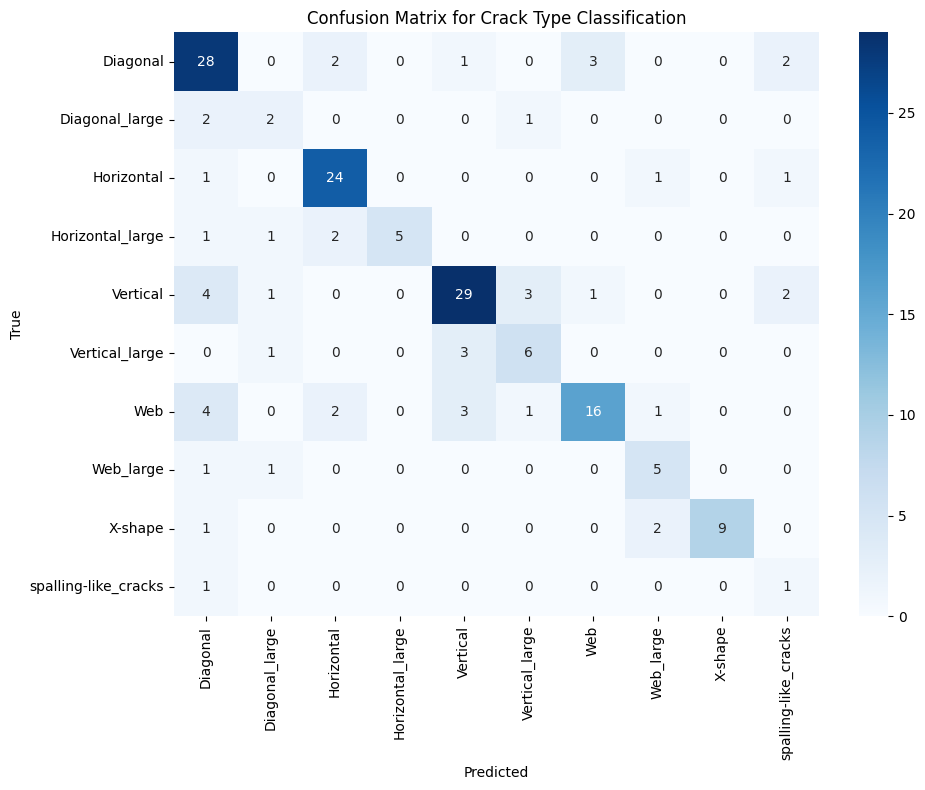

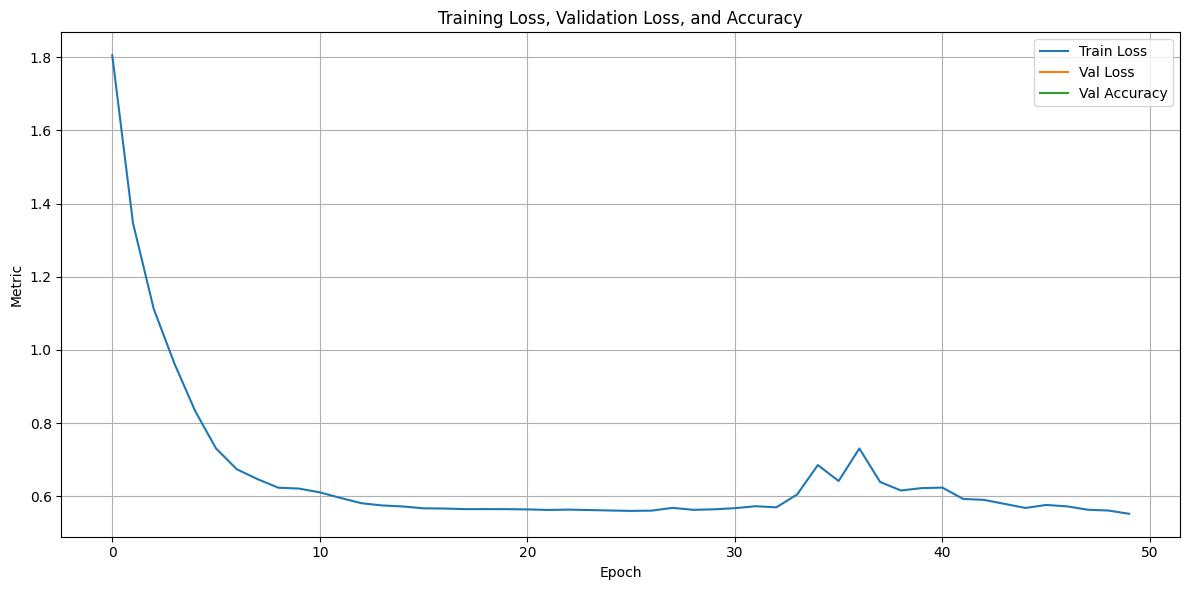

In [ ]:
# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
class_names = dataset.classes

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Crack Type Classification")
plt.tight_layout()
plt.show()

# === Learning Curve ===
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training Loss, Validation Loss, and Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()